## MMD GAN implmentation



by Sara, Mariia et Chems 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

In [3]:

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

## import mnist  

In [4]:

# Load MNIST data
batch_size=128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


torch.Size([64, 1, 28, 28])


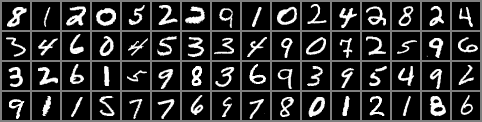

In [5]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## 2. Generator

In [5]:
# Define the generator network
# todo data normalized ? 
# with a DCGAN 
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()# -1 to 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img


## 2.2 DCGANGenerator

Inspired fromt he binkowki code but reimplemented in pytorch 

In [28]:
import torch
import torch.nn as nn



class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim, img_size, channels):
        super(DCGANGenerator, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        img = self.model(z)
        return img


### Inspired form the wgan TP 

In [9]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary
# device = torch.device("cuda:1")
# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)



## Display samples of the generator 

In [10]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


## Instaciating the model 

In [15]:
device = torch.device('cuda:1')

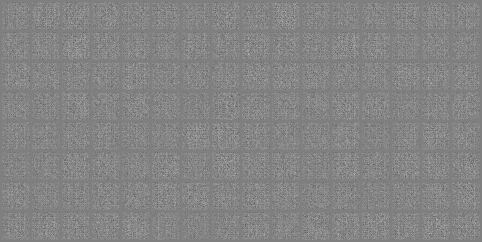

In [39]:

# Create the generator and discriminator
G = DCGenerator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

## 3. Feature Extractor

In [40]:

# Define the feature extractor network (acting as a discriminator)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

    def forward(self, img):
        features = self.model(img)
        return features

## Feature extraction

### Extracting features from LeNet : a trained model 

In [4]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = 1, output channels = 6, kernel size = 5x5
    # input image size = (32, 32), image output size = (28, 28)
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=1, padding=2)
    
    # input channel = 6, output channels = 16, kernel size = 5x5
    # input image size = (14, 14), output image size = (10,10 )
    self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=1, padding=0)

    # input dim = 5x5x16 ( H x W x C), output dim = 120
    self.lin1 = torch.nn.Linear(in_features=5*5*16, out_features=120)
    
    # input dim = 120, output dim = 84
    self.lin2 = torch.nn.Linear(in_features=120, out_features=84)
    
    # input dim = 84, output dim = 10
    self.output = torch.nn.Linear(in_features=84, out_features=10)
   


  def forward(self, x):

    # Max Pooling with kernel size = 2
    # output size = (14, 14)
    # TODO
    x = self.conv1(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    
    x = self.conv2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    # flatten the feature maps into a long vector
    x = x.view(x.size(0), -1)

    # Fully connected layer
    x = self.lin1(x)
    x = F.relu(x)

    x = self.lin2(x)
    x = F.relu(x)

    x = self.output(x)
    x = F.softmax(x, dim=1)
    return x

In [5]:
lenet = LeNet()
print(lenet)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=400, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [7]:
from torch import optim
def get_optimizer(net, lr, wd, momentum):
  optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Feature extractor : Training and testing loops for CNN

In [8]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [9]:
from tqdm import tqdm
def test(net, data_loader, cost_function, device='cuda:1'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cuda:1'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(tqdm(data_loader)):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [10]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cuda:1',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=10):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5
  net = LeNet()
  net = net.to(device)
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)
  

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  return net


### Training LeNet classifier

In [11]:
lenet = main(epochs=10)

Before training:


/home/infres/benaziza-22/anaconda3/envs/ima/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


	 Training loss 0.01804, Training accuracy 10.93
	 Validation loss 0.00906, Validation accuracy 10.81
	 Test loss 0.00921, Test accuracy 11.01
-----------------------------------------------------


100%|██████████| 235/235 [00:08<00:00, 27.04it/s]


Epoch: 1
	 Training loss 0.01803, Training accuracy 13.29
	 Validation loss 0.00904, Validation accuracy 16.38
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 30.54it/s]


Epoch: 2
	 Training loss 0.01780, Training accuracy 27.92
	 Validation loss 0.00811, Validation accuracy 45.47
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 30.80it/s]


Epoch: 3
	 Training loss 0.01395, Training accuracy 69.52
	 Validation loss 0.00674, Validation accuracy 74.66
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 31.30it/s]


Epoch: 4
	 Training loss 0.01331, Training accuracy 76.39
	 Validation loss 0.00668, Validation accuracy 76.22
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 31.25it/s]


Epoch: 5
	 Training loss 0.01294, Training accuracy 81.18
	 Validation loss 0.00637, Validation accuracy 84.51
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 30.34it/s]


Epoch: 6
	 Training loss 0.01259, Training accuracy 85.74
	 Validation loss 0.00631, Validation accuracy 85.67
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 30.89it/s]


Epoch: 7
	 Training loss 0.01249, Training accuracy 86.91
	 Validation loss 0.00629, Validation accuracy 86.41
-----------------------------------------------------


100%|██████████| 235/235 [00:08<00:00, 26.56it/s]


Epoch: 8
	 Training loss 0.01243, Training accuracy 87.47
	 Validation loss 0.00627, Validation accuracy 86.82
-----------------------------------------------------


100%|██████████| 235/235 [00:08<00:00, 28.09it/s]


Epoch: 9
	 Training loss 0.01240, Training accuracy 87.83
	 Validation loss 0.00625, Validation accuracy 87.15
-----------------------------------------------------


100%|██████████| 235/235 [00:07<00:00, 31.08it/s]


Epoch: 10
	 Training loss 0.01237, Training accuracy 88.19
	 Validation loss 0.00626, Validation accuracy 87.00
-----------------------------------------------------
After training:
	 Training loss 0.01239, Training accuracy 88.02
	 Validation loss 0.00626, Validation accuracy 87.00
	 Test loss 0.00634, Test accuracy 87.30
-----------------------------------------------------


## Transferring the features to the feature extractor

In [26]:
class LeFeatureExtractor(nn.Module):
    def __init__(self, model):
        self.features = nn.Sequential(*list(model.children())[:-3])

    def forward(self, x):
        return self.features(x)

In [15]:
lefeature_extractor = LeFeatureExtractor(lenet)

## MMD LOSS
$$
MMD^2_u(X, Y) = \frac{1}{m(m-1)} \sum_{i \neq j}^{m} k(x_i, x_j) +
\frac{1}{n(n-1)} \sum_{i \neq j}^{n} k(y_i, y_j) -
\frac{2}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} k(x_i, y_j)
$$

In [41]:

# MMD loss function
def mmd_loss(real_features, fake_features, kernel):
    mmd = torch.mean(kernel(real_features, real_features)) \
        + torch.mean(kernel(fake_features, fake_features)) \
        - 2 * torch.mean(kernel(real_features, fake_features))
    return mmd


### Kernel : Gaussian 

$$
k^{rbf}_\sigma(x, y) = \exp \left( - \frac{1}{2\sigma^2} \|x - y\|^2 \right)
$$

In [42]:
# Gaussian kernel function
# todo : check if the params are good and if it is possible to find better 
def gaussian_kernel(x, y, sigma=1.0):
    beta = 1.0 / (2.0 * sigma ** 2)
    dist = torch.cdist(x, y, p=2)
    return torch.exp(-beta * dist)


### Qunadtric kernle as it was implemented in the binkowski paper 

In [27]:
import torch

def mix_rq_kernel(X, Y, alphas=[.1, 1., 10.], wts=None, K_XY_only=False, add_dot=.0):
    """
    Rational quadratic kernel
    http://www.cs.toronto.edu/~duvenaud/cookbook/index.html
    """
    if wts is None:
        wts = [1.] * len(alphas)

    XX = torch.matmul(X, X.t())
    XY = torch.matmul(X, Y.t())
    YY = torch.matmul(Y, Y.t())

    X_sqnorms = torch.diag(XX)
    Y_sqnorms = torch.diag(YY)

    r = lambda x: x.unsqueeze(0)
    c = lambda x: x.unsqueeze(1)

    K_XX, K_XY, K_YY = 0., 0., 0.

    XYsqnorm = torch.clamp(-2. * XY + c(X_sqnorms) + r(Y_sqnorms), min=0.)

    for alpha, wt in zip(alphas, wts):
        logXY = torch.log(1. + XYsqnorm/(2.*alpha))
        K_XY += wt * torch.exp(-alpha * logXY)
    if add_dot > 0:
        K_XY += torch.tensor(add_dot, dtype=torch.float32) * XY

    if K_XY_only:
        return K_XY

    XXsqnorm = torch.clamp(-2. * XX + c(X_sqnorms) + r(X_sqnorms), min=0.)
    YYsqnorm = torch.clamp(-2. * YY + c(Y_sqnorms) + r(Y_sqnorms), min=0.)

    for alpha, wt in zip(alphas, wts):
        logXX = torch.log(1. + XXsqnorm/(2.*alpha))
        logYY = torch.log(1. + YYsqnorm/(2.*alpha))
        K_XX += wt * torch.exp(-alpha * logXX)
        K_YY += wt * torch.exp(-alpha * logYY)
    if add_dot > 0:
        K_XX += torch.tensor(add_dot, dtype=torch.float32) * XX
        K_YY += torch.tensor(add_dot, dtype=torch.float32) * YY

    return K_XX, K_XY, K_YY


### Initializing the network and the optimizers

In [59]:

# Initialize networks and optimizers
latent_dim = 100
generator = DCGenerator().to(device)
feature_extractor = FeatureExtractor().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(feature_extractor.parameters(), lr=0.0002)



In [33]:

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :, :, :]
        n = b
    else:
        x = x[0:n, :, :, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients = gradients.view(b, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)  # Add epsilon to avoid numerical instability

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

### Training loop 

In [1]:
from tqdm import tqdm
from time import time
# todo garder les loss, et le timing 
losses = []
# Training loop
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    t1 = time()
    for batch_idx, (real_imgs, _) in enumerate(tqdm(train_loader)):
        real_imgs = real_imgs.cuda()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), latent_dim).cuda()
        fake_imgs = G(z)

        # Extract features
        real_features = feature_extractor(real_imgs)
        fake_features = feature_extractor(fake_imgs)

        # Compute MMD loss
        loss = mmd_loss(real_features, fake_features, gaussian_kernel)

        # Update generator
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

        epoch_loss += loss.item()
        
    t2 = time()
    epoch_time = t2-t1
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}  Epoch Time : {epoch_time} ")


NameError: name 'train_loader' is not defined

In [53]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assume Generator, Discriminator, mmd_loss, gradient_penalty are defined
# Also, assume the device is set (e.g., 'cuda' or 'cpu')

num_epochs = 5
nz = 100  # Latent vector size
batch_size = 64
lr = 0.0002
gpw = 0.1  # Gradient penalty weight

# Initialize models and optimizers
G = DCGenerator().to(device)
D = Discriminator().to(device)
optimG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        ############################
        # Update Discriminator D
        ############################
        
        # Generate fake images
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = G(z).detach()
        
        # Calculate MMD loss
        mmd_d_loss = mmd_loss(real_images, fake_images, kernel=gaussian_kernel)
        
        # Calculate gradient penalty
        gp = gradient_penalty(D, real_images, fake_images)
        
        # Total loss for Discriminator
        D_loss = mmd_d_loss + gpw * gp
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()
        
        ############################
        # Update Generator G
        ############################
        
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = G(z)
        
        # MMD loss for Generator
        G_loss = mmd_loss(real_images, fake_images, kernel=gaussian_kernel)
        
        optimG.zero_grad()
        G_loss.backward()
        optimG.step()
        
        # Logging losses
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], '
                  f'D Loss: {D_loss.item()}, G Loss: {G_loss.item()}')
    
    # Save model checkpoints
    torch.save(G.state_dict(), f'generator_epoch_{epoch+1}.pth')
    torch.save(D.state_dict(), f'discriminator_epoch_{epoch+1}.pth')

print('Training complete.')


Epoch 1/5:   0%|          | 3/938 [00:01<04:14,  3.67it/s]

Epoch [1/5], Step [0/938], D Loss: 0.3205539286136627, G Loss: 0.3032737970352173


Epoch 1/5:  11%|█▏        | 106/938 [00:04<00:27, 30.20it/s]

Epoch [1/5], Step [100/938], D Loss: 0.10554654151201248, G Loss: 0.10516756772994995


Epoch 1/5:  22%|██▏       | 206/938 [00:07<00:23, 31.11it/s]

Epoch [1/5], Step [200/938], D Loss: 0.10487730801105499, G Loss: 0.10451942682266235


Epoch 1/5:  33%|███▎      | 305/938 [00:10<00:21, 30.04it/s]

Epoch [1/5], Step [300/938], D Loss: 0.10520054399967194, G Loss: 0.10502305626869202


Epoch 1/5:  43%|████▎     | 405/938 [00:13<00:16, 32.58it/s]

Epoch [1/5], Step [400/938], D Loss: 0.0879516527056694, G Loss: 0.08774834871292114


Epoch 1/5:  54%|█████▍    | 505/938 [00:16<00:13, 32.04it/s]

Epoch [1/5], Step [500/938], D Loss: 0.09251446276903152, G Loss: 0.0930970311164856


Epoch 1/5:  64%|██████▍   | 605/938 [00:20<00:10, 31.60it/s]

Epoch [1/5], Step [600/938], D Loss: 0.08668792247772217, G Loss: 0.08643081784248352


Epoch 1/5:  75%|███████▌  | 705/938 [00:23<00:07, 32.76it/s]

Epoch [1/5], Step [700/938], D Loss: 0.09156884253025055, G Loss: 0.09225323796272278


Epoch 1/5:  86%|████████▌ | 805/938 [00:26<00:04, 30.60it/s]

Epoch [1/5], Step [800/938], D Loss: 0.09322897344827652, G Loss: 0.09312325716018677


Epoch 1/5:  96%|█████████▋| 905/938 [00:29<00:01, 30.63it/s]

Epoch [1/5], Step [900/938], D Loss: 0.09585290402173996, G Loss: 0.09551477432250977


Epoch 2/5:   0%|          | 2/938 [00:00<06:42,  2.33it/s]

Epoch [2/5], Step [0/938], D Loss: 0.09013061970472336, G Loss: 0.0903083086013794


Epoch 2/5:  11%|█         | 101/938 [00:07<01:22, 10.15it/s]

Epoch [2/5], Step [100/938], D Loss: 0.09095075726509094, G Loss: 0.09089457988739014


Epoch 2/5:  22%|██▏       | 207/938 [00:17<00:27, 26.70it/s]

Epoch [2/5], Step [200/938], D Loss: 0.08438785374164581, G Loss: 0.08441394567489624


Epoch 2/5:  33%|███▎      | 305/938 [00:20<00:21, 29.71it/s]

Epoch [2/5], Step [300/938], D Loss: 0.0874355286359787, G Loss: 0.08745133876800537


Epoch 2/5:  43%|████▎     | 407/938 [00:23<00:17, 30.63it/s]

Epoch [2/5], Step [400/938], D Loss: 0.09335688501596451, G Loss: 0.09332960844039917


Epoch 2/5:  54%|█████▍    | 507/938 [00:27<00:16, 26.65it/s]

Epoch [2/5], Step [500/938], D Loss: 0.08864088356494904, G Loss: 0.0884777307510376


Epoch 2/5:  65%|██████▍   | 607/938 [00:30<00:10, 30.75it/s]

Epoch [2/5], Step [600/938], D Loss: 0.09343564510345459, G Loss: 0.09316515922546387


Epoch 2/5:  75%|███████▌  | 707/938 [00:33<00:07, 32.38it/s]

Epoch [2/5], Step [700/938], D Loss: 0.08361723273992538, G Loss: 0.08365175127983093


Epoch 2/5:  86%|████████▌ | 807/938 [00:36<00:04, 31.70it/s]

Epoch [2/5], Step [800/938], D Loss: 0.09475117176771164, G Loss: 0.09480273723602295


Epoch 2/5:  97%|█████████▋| 907/938 [00:39<00:01, 30.44it/s]

Epoch [2/5], Step [900/938], D Loss: 0.09118649363517761, G Loss: 0.09123390913009644


Epoch 3/5:   0%|          | 3/938 [00:00<02:49,  5.50it/s]

Epoch [3/5], Step [0/938], D Loss: 0.09633819013834, G Loss: 0.09642696380615234


Epoch 3/5:  11%|█▏        | 106/938 [00:03<00:26, 30.96it/s]

Epoch [3/5], Step [100/938], D Loss: 0.08824272453784943, G Loss: 0.08849707245826721


Epoch 3/5:  22%|██▏       | 206/938 [00:06<00:21, 33.84it/s]

Epoch [3/5], Step [200/938], D Loss: 0.09036597609519958, G Loss: 0.09039434790611267


Epoch 3/5:  33%|███▎      | 306/938 [00:09<00:19, 33.06it/s]

Epoch [3/5], Step [300/938], D Loss: 0.09513826668262482, G Loss: 0.09514346718788147


Epoch 3/5:  43%|████▎     | 406/938 [00:13<00:16, 32.28it/s]

Epoch [3/5], Step [400/938], D Loss: 0.09421158581972122, G Loss: 0.09426459670066833


Epoch 3/5:  54%|█████▍    | 507/938 [00:16<00:13, 32.45it/s]

Epoch [3/5], Step [500/938], D Loss: 0.08013715595006943, G Loss: 0.08038124442100525


Epoch 3/5:  65%|██████▍   | 606/938 [00:19<00:10, 33.17it/s]

Epoch [3/5], Step [600/938], D Loss: 0.07822013646364212, G Loss: 0.0785071849822998


Epoch 3/5:  75%|███████▌  | 705/938 [00:23<00:11, 20.00it/s]

Epoch [3/5], Step [700/938], D Loss: 0.07883413881063461, G Loss: 0.07925653457641602


Epoch 3/5:  86%|████████▌ | 805/938 [00:26<00:03, 33.26it/s]

Epoch [3/5], Step [800/938], D Loss: 0.07735501229763031, G Loss: 0.07722970843315125


Epoch 3/5:  96%|█████████▋| 905/938 [00:29<00:01, 30.15it/s]

Epoch [3/5], Step [900/938], D Loss: 0.08356232196092606, G Loss: 0.08389720320701599


Epoch 4/5:   0%|          | 2/938 [00:01<08:52,  1.76it/s]

Epoch [4/5], Step [0/938], D Loss: 0.08315937221050262, G Loss: 0.08279907703399658


Epoch 4/5:  11%|█         | 101/938 [00:16<01:24,  9.93it/s]

Epoch [4/5], Step [100/938], D Loss: 0.08113693445920944, G Loss: 0.08117517828941345


Epoch 4/5:  22%|██▏       | 203/938 [00:26<00:59, 12.45it/s]

Epoch [4/5], Step [200/938], D Loss: 0.07580620795488358, G Loss: 0.07565334439277649


Epoch 4/5:  33%|███▎      | 306/938 [00:29<00:20, 31.54it/s]

Epoch [4/5], Step [300/938], D Loss: 0.0880029946565628, G Loss: 0.08813011646270752


Epoch 4/5:  43%|████▎     | 405/938 [00:32<00:17, 30.66it/s]

Epoch [4/5], Step [400/938], D Loss: 0.08673863112926483, G Loss: 0.0864747166633606


Epoch 4/5:  54%|█████▍    | 505/938 [00:35<00:14, 29.02it/s]

Epoch [4/5], Step [500/938], D Loss: 0.07711664587259293, G Loss: 0.07727280259132385


Epoch 4/5:  65%|██████▍   | 606/938 [00:39<00:10, 31.19it/s]

Epoch [4/5], Step [600/938], D Loss: 0.08040185272693634, G Loss: 0.08057254552841187


Epoch 4/5:  75%|███████▌  | 706/938 [00:42<00:07, 32.59it/s]

Epoch [4/5], Step [700/938], D Loss: 0.0802200436592102, G Loss: 0.08005154132843018


Epoch 4/5:  86%|████████▌ | 806/938 [00:45<00:04, 30.71it/s]

Epoch [4/5], Step [800/938], D Loss: 0.09100604802370071, G Loss: 0.09129026532173157


Epoch 4/5:  96%|█████████▋| 905/938 [00:50<00:01, 30.53it/s]

Epoch [4/5], Step [900/938], D Loss: 0.07401726394891739, G Loss: 0.07404777407646179


Epoch 5/5:   0%|          | 4/938 [00:00<01:56,  8.00it/s]

Epoch [5/5], Step [0/938], D Loss: 0.07709359377622604, G Loss: 0.07695373892784119


Epoch 5/5:  11%|█▏        | 107/938 [00:03<00:26, 31.43it/s]

Epoch [5/5], Step [100/938], D Loss: 0.07875771075487137, G Loss: 0.07872188091278076


Epoch 5/5:  22%|██▏       | 205/938 [00:07<00:24, 29.55it/s]

Epoch [5/5], Step [200/938], D Loss: 0.07869832962751389, G Loss: 0.07843071222305298


Epoch 5/5:  33%|███▎      | 305/938 [00:10<00:19, 32.66it/s]

Epoch [5/5], Step [300/938], D Loss: 0.08209314197301865, G Loss: 0.08236974477767944


Epoch 5/5:  43%|████▎     | 405/938 [00:13<00:15, 33.40it/s]

Epoch [5/5], Step [400/938], D Loss: 0.07158862799406052, G Loss: 0.0712215006351471


Epoch 5/5:  54%|█████▍    | 505/938 [00:16<00:14, 30.74it/s]

Epoch [5/5], Step [500/938], D Loss: 0.08701109886169434, G Loss: 0.08718493580818176


Epoch 5/5:  64%|██████▍   | 601/938 [00:19<00:10, 32.67it/s]

Epoch [5/5], Step [600/938], D Loss: 0.08037521690130234, G Loss: 0.08018848299980164


Epoch 5/5:  75%|███████▌  | 704/938 [00:22<00:07, 30.22it/s]

Epoch [5/5], Step [700/938], D Loss: 0.07594498246908188, G Loss: 0.07575663924217224


Epoch 5/5:  86%|████████▌ | 804/938 [00:25<00:04, 32.16it/s]

Epoch [5/5], Step [800/938], D Loss: 0.07637160271406174, G Loss: 0.07653510570526123


Epoch 5/5:  97%|█████████▋| 907/938 [00:29<00:00, 33.73it/s]

Epoch [5/5], Step [900/938], D Loss: 0.07840588688850403, G Loss: 0.07822826504707336


Epoch 5/5: 100%|██████████| 938/938 [00:30<00:00, 30.33it/s]

Training complete.


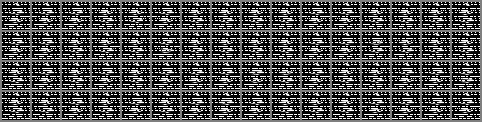

In [57]:
# display the results
show(G, zviz)

In [ ]:
# Save final generator in a variable for later use
dcgan = DCGenerator()
dcgan.load_state_dict(G.state_dict())

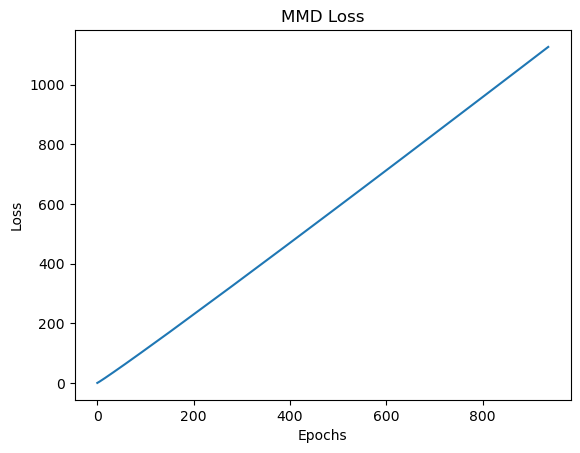

In [30]:
# print the loss graph 
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MMD Loss')
plt.show()


In [ ]:
from tqdm import tqdm

# Training loop
losses = []
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    for batch_idx, (real_imgs, _) in enumerate(tqdm(train_loader)):
        real_imgs = real_imgs.cuda()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), latent_dim).cuda()
        fake_imgs = generator(z)

        # Extract features
        real_features = feature_extractor(real_imgs)
        fake_features = feature_extractor(fake_imgs)

        # Compute MMD loss
        loss = mmd_loss(real_features, fake_features, gaussian_kernel)

        # Update generator
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()

        epoch_loss += loss.item()
        losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")


## Trainig from Practical Work 

In [ ]:
# display loss 
from tqdm import tqdm
import torch
import time

torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
nz = 100
batch_size = 64

# Assuming Generator and Discriminator classes, and weights_init function are already defined
G = Generator().to(device)
D = Discriminator().to(device)  # Not used in MMD-GAN, but keep for structure
G.apply(weights_init)

optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size, nz, 1, 1).to(device)


t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        
        # Compute loss for D
        Dloss_real = D(real).mean()
        Dloss_fake = D(faked).mean()
        Dloss = Dloss_fake - Dloss_real
        # Compute gradient penalty
        gp = gradient_penalty(D, real, faked)
        Dloss_total = Dloss + gpw * gp
        # Update D
        # D.zero_grad()
        # Dloss_total.backward(retain_graph=True)  # Retain graph for the gradient penalty
        # optimD.step()

        ############################
        # Update G network
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        Gloss = -D(fake).mean()
        G.zero_grad()
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch + 1, num_epochs, i, len(train_loader), time.time() - t0, Dloss.item(), Gloss.item(), lipconstant(D, real, faked)))
            show(G, zviz)

print('Total learning time = ', time.time() - t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


## Showing results : with the basic feature extractor 
Note : Don't rerun this except if you train with the good params : 
- Basic generator 
- basic feature extractor 

In [54]:
import torch
import matplotlib.pyplot as plt

# Function to display and save a batch of generated images
def show_generated_images(generator, latent_dim, n_images=25):
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(n_images, latent_dim).cuda()  # Generate random noise
    with torch.no_grad():
        generated_images = generator(z).cpu()  # Generate images from the noise
    generator.train()  # Set the generator back to training mode

    # Plot the generated images in a grid
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Images')
    plt.show()

# Generate and visualize images
show_generated_images(Generator, latent_dim, n_images=25)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [25, 100]

## Showing results with a feature extraction based on the last layer of LeNet

Note : Don't rerun this (to avoid losing displayed results) except if you train the model with the : 
- basic generator 
- LeNet as a feature extractor 

In [48]:
import torch
import matplotlib.pyplot as plt 

# Function to display and save a batch of generated images
def show_generated_images(generator, latent_dim, n_images=25):
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(n_images, latent_dim).cuda()  # Generate random noise
    with torch.no_grad():
        generated_images = generator(z).cpu()  # Generate images from the noise
    generator.train()  # Set the generator back to training mode

    # Plot the generated images in a grid
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = generated_images[i].squeeze(0)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Images')
    plt.show()

# Generate and visualize images
show_generated_images(generator, latent_dim, n_images=25)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [25, 100]

## Display samples

In [49]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

In [50]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

NameError: name 'imshow' is not defined

## Saving Models

In [45]:

import os
import torch

# Define the directory to save model weights
save_dir = 'model_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [47]:
# Function to save model weights
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to {filepath}")

# Example usage:

model = lenet  # Replace with your model variable
save_path = 'model_weights/lenet10epochs.pth'
save_model_weights(model, save_path)

Model weights saved to model_weights/lenet10epochs.pth


### Load Model 

In [ ]:
def load_model_weights(model, filepath):
    model.load_state_dict(torch.load(filepath, map_location=device))
    print(f"Les poids du modèle ont été chargés à partir de {filepath}")

## References 

- https://openreview.net/pdf?id=r1lUOzWCW : DEMYSTIFYING MMD GANS
- https://github.com/hindupuravinash/the-gan-zoo?tab=readme-ov-file : Gan ZOO